# Setting up the colab
First, make sure your runtime is using a GPU accelerator. In the "Runtime" menu,
select "Change runtime type" and select GPU as the hardware accelerator.

Then, run the cell below to install all the necessary packages.

In [ ]:
# @title Installs and imports (run me first!)
!pip install pyglet~=1.3.2
!apt install -y graphviz
!pip install flax
!pip install graphviz
!pip install pyvirtualdisplay
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install 'gym[atari]'
!pip install -U dopamine-rl

import flax
from graphviz import Digraph
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp

from IPython.display import HTML
from pprint import pprint
import logging
from pyvirtualdisplay import Display
logging.getLogger("pyvirtualdisplay").setLevel(logging.ERROR)

display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display)

# An introduction to reinforcement learning

Reinforcement learning methods are used for sequential decision making in uncertain environments. It is typically framed as an agent (the learner) interacting with an environment which provides the agent with _reinforcement_ (positive or negative), based on the agent's decisions. The agent leverages this reinforcement to update its behaviour in an aim to get closer to acting _optimally_. In interacting with the uncertain environment, the agent is also learning about the _dynamics_ of the underlying system.

The notebook is roughly organized as follows:
1.  A simple motivating example is presented to illustrate some of the main points and challenges.
2.  Markov decision processes (MDPs), the mathematical formalism used to express these problems, is introduced.
3.  Exact tabular methods are presented, which can be used when the environment is fully known. These methods form the foundation for the learning algorithms in uncertain environments.
4.  Value-based learning algorithms are introduced, and related algorithms are also presented.
5.  The methods introduced are put to the test on a simple MDP.
6.  Deep reinforcement learning is introduced, along with some implementation details.
7.  We use deep reinforcement learning to learn a policy on a larger MDP.
8.  Resources for further study are provided.


# Markov decision processes
More formally, the problem is typically expressed as a Markov decision process
$\langle\mathcal{S},\mathcal{A},R,P,\gamma\rangle$, where:
*  $\mathcal{S}$ is a finite set of _states_ that the agent "inhabits". You can also consider continuous state spaces, but for this notebook we will only be considering the finite kind.
*  $\mathcal{A}$ is a finite set of _actions_ that the agent can perform from each state. In the vast majority of cases, it is assumed that all actions are available in all states. Action spaces can also be continuous, but we will be limiting ourselves to finite action spaces in this notebook.
*  $R:\mathcal{S}\times\mathcal{A}\rightarrow [R_{min}, R_{max}]\subset\mathbb{R}$ is a bounded reward (or cost) function which provides the agent with (positive or negative) reinforcement.
*  $P:\mathcal{S}\times\mathcal{A}\rightarrow\Delta(\mathcal{S})$ encodes the transition dynamics, where $P(s, a)(s')$ is the probability of ending in state $s'$ after taking action $a$ from state $s$.
*  $\gamma\in[0, 1)$ is a discount factor.

The notation $\Delta(X)$ stands for the set of probability distributions over a set $X$.

Since the discount factor $\gamma$ is strictly less than $1$, it encourages the agent to accumulate rewards as quickly as possible. In the motivating example above, it means the optimal policy is also the shortest path to the big star. Having $\gamma = 1$ would mean that the agent perceives no difference between taking a short or long path to the gold star.

The agent interacts with the environment in discrete time steps. If at time step $t$ the agent is in state $s_t$ and chooses action $a_t$, the environment responds with a new state $s_{t+1}\sim P(s_t, a_t)$ and a reward $R(s_t, a_t)$.



## Policies and value functions
A policy $\pi$ is a mapping from states to a distribution over actions: $\pi:\mathcal{S}\rightarrow\Delta(\mathcal{A})$, and encodes the agent's _behaviour_. The _value_ of a policy $\pi$ from an initial state $s_0$ is encoded as:

$V^{\pi}(s_0) = \left[\sum_{t=0}^{\infty}\gamma^t R(s_t, a_t) | a_t\sim\pi(s_t),s_{t+1}\sim P(s_t, a_t)\right]$

This is quantifying the expected sum of discounted rewards when starting from state $s_0$ and following policy $\pi$. It turns out we can express value functions for any state $s$ via the recurrence:

$V^{\pi}(s) = \mathbb{E}_{a\sim\pi(s)}\left[R(s, a) + \gamma\mathbb{E}_{s'\sim P(s, a)}[V^{\pi}(s')]\right]$

or equivalently, replacing the expectation over actions with a summation:

$V^{\pi}(s) = \sum_{a\in\mathcal{A}}\pi(s)(a)\left[R(s, a) + \gamma\sum_{s'\in\mathcal{S}} P(s, a)(s')V^{\pi}(s')\right]$

We may sometimes also be interested in the value of performing action $a$ from state $s$, and _then_ following policy $\pi$:

$Q^{\pi}(s, a) = R(s, a) + \gamma\mathbb{E}_{s'\sim P(s, a)}[V^{\pi}(s')]$



## Optimal policies and value functions
The goal of the agent is to find a policy $\pi^*$ that dominates all other policies: $V^* := V^{\pi^*} \geq V^{\pi}$ for all $\pi$. It turns out that there is always a deterministic policy that achieves the optimum. The Bellman optimality equations express this via the recurrence:

$V^*(s) = \max_{a\in\mathcal{A}}\left[R(s, a) + \gamma\sum_{s'\in\mathcal{S}} P(s, a)(s')V^*(s')\right]$

The state-action value function can be defined in a similar way as above:

$Q^*(s, a) = R(s, a) + \gamma\mathbb{E}_{s'\sim P(s, a)}[V^*(s')]$

Clearly, we can compute $Q^*$ from $V^*$, and once we know $Q^*$ we can find $\pi^*$ via:

$\pi^*(s) = \arg\max_{a\in\mathcal{A}}Q^*(s, a)$

The important question, then, is _how_ do we find $\pi^*$, $V^*$, and/or $Q^*$? Read on and find out!

To begin with, run the first two cells below to install and import all necessary packages.

# Computing $V^*$ exactly
If we have access to $P$ and $R$, then we can compute $V^*$ in a few ways. We will explore two common methods here:
*  Value iteration
*  Policy iteration

When the transition and reward dynamics are known, these problems are typically referred to as _planning_ problems, which has its own field of active research. In this scenario, the "agent" does not need to interact with an environment to gather information for improving its policy. There is a close relationship between planning and reinforcement learning, and many lines of research sit at their intersection.

For our purposes, it will be useful to review some solutions to the planning problem, as they will serve as foundations for the learning algorithms we present further down.

## Value iteration
In Value iteration we are continuously updating an estimate $V_{t+1}$ by leveraging our previous estimate $V_t$.

$V_{t+1}(s) := \max_{a\in\mathcal{A}} \left[ R(s, a) + \gamma \sum_{s'\in\mathcal{S}}P(s, a)(s') V_t(s') \right]$

This is typically referred to as the _Bellman backup_. It can be shown that, starting from an initial estimate $V_0$, $\lim_{t\rightarrow\infty}V_t = V^*$.

This gives us the value iteration algorithm:
1.  Initialize $V\equiv 0$
1.  Loop until convergence:
    *  For every $s\in\mathcal{S}$:<br>$V(s)\leftarrow \max_{a\in\mathcal{A}} \left[ R(s, a) + \gamma \sum_{s'\in\mathcal{S}}P(s, a)(s') V(s') \right]$
1.  Return $V$

It will be useful to think of the functions above as vectors, which then allows
us to do the Bellman backup with matrix operations. If we assume our matrices have the following shapes:
```
P.shape = [num_states, num_actions, num_states]
R.shape = [num_states, num_actions]
V.shape = [num_states]
Q.shape = [num_states, num_actions]
```
Then we can compute $V$ with two lines of `numpy` code:
```
import numpy as np
Q = R + gamma * np.matmul(P, V)
V = np.max(Q, axis=1)
```

Alternatively, we can use the [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) function, which can help clarify the dimensions along which the multiplication is happening:
```
Q = R + gamma * np.einsum('sat,t->sa', P, V)
V = np.max(Q, axis=1)
```

As mentioned above, once we have $V^*$, we can compute $Q^*$ and $\pi^*$.

The code cell below is an implementation of value iteration.

In [ ]:
def value_iteration(P, R, gamma, tolerance=1e-3):
  """Find V* using value iteration.

  Args:
    P: numpy array defining transition dynamics. Shape: |S| x |A| x |S|.
    R: numpy array defining rewards. Shape: |S| x |A|.
    gamma: float, discount factor.
    tolerance: float, tolerance level for computation.

  Returns:
    V*: numpy array of shape ns.
    Q*: numpy array of shape ns x na.
  """
  assert P.shape[0] == P.shape[2]
  assert P.shape[0] == R.shape[0]
  assert P.shape[1] == R.shape[1]
  ns = P.shape[0]
  na = P.shape[1]
  V = onp.zeros(ns)
  Q = onp.zeros((ns, na))
  error = tolerance * 2
  while error > tolerance:
    # This is the Bellman backup (onp.einsum FTW!).
    Q = R + gamma * onp.einsum('sat,t->sa', P, V)
    new_V = onp.max(Q, axis=1)
    error = onp.max(onp.abs(V - new_V))
    V = onp.copy(new_V)
  return V, Q

## Policy iteration
Instead of iterating over $V_t$, we can iterate over $\pi_t$ and stop once the
policy is no longer changing. The algorithm proceeds as follows:

1.  Initialize $\pi$ arbitrarily. For simplicity we will assume it is a matrix of shape `[num_states, num_actions]` with only one `1.0` for each row (i.e. a deterministic policy).
1.  While $\pi$ is changing:
    *  $Q(s, a) = R(s, a) + \gamma\sum_{s'\in\mathcal{S}}P(s, a)(s')Q(s', \pi(s'))$
    *  $\pi(s) = \arg\max Q(s, \cdot)$
1.  $Q(s, a) = R(s, a) + \gamma\sum_{s'\in\mathcal{S}}P(s, a)(s')Q(s', \pi(s'))$
1.  $V(s) = \max_{a\in\mathcal{A}}Q(s, a)$
1.  Return $V$

Notice that, in contrast to value iteration, here we compute $Q^*$ and $V^*$ from $\pi^*$.

In [ ]:
def policy_iteration(P, R, gamma):
  """Find V* using policy iteration.

  Args:
    P: numpy array defining transition dynamics. Shape: |S| x |A| x |S|.
    R: numpy array defining rewards. Shape: |S| x |A|.
    gamma: float, discount factor.

  Returns:
    V*: numpy array of shape ns.
    Q*: numpy array of shape ns x na.
  """
  assert P.shape[0] == P.shape[2]
  assert P.shape[0] == R.shape[0]
  assert P.shape[1] == R.shape[1]
  ns = P.shape[0]
  na = P.shape[1]
  V = onp.zeros(ns)
  Q = onp.zeros((ns, na))
  pi = onp.zeros((ns, na))
  for s in range(ns):
    pi[s, onp.random.choice(na)] = 1.
  policy_stable = False
  while not policy_stable:
    old_pi = onp.copy(pi)
    # Extract V from Q using pi.
    V = [Q[s, onp.argmax(pi[s])] for s in range(ns)]
    Q = R + gamma * onp.einsum('sat,t->sa', P, V)
    pi = onp.zeros((ns, na))
    for s in range(ns):
      pi[s, onp.argmax(Q[s])] = 1.
    policy_stable = onp.array_equal(pi, old_pi)
  V = [Q[s, onp.argmax(pi[s])] for s in range(ns)]
  Q = R + gamma * onp.einsum('sat,t->sa', P, V)
  V = [Q[s, onp.argmax(pi[s])] for s in range(ns)]
  return V, Q

## Learning $V^*$
What if one does _not_ have access to $P$ and $R$? This is the most common scenario in reinforcement learning problems, and here the agents must _learn_ how to behave by interacting with the environment.

The diagram below depicts this pictorially:
*  The _agent_, in state $s$, picks an action $a$ from its policy $\pi(s)$ and sends this action to the environment.
*  The _environment_ returns a new state $s'\sim P(s, a)$ and reward $R(s, a)$ to the agent.
*  The agent can then use this new information to update its policy $\pi$.

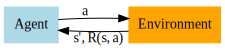

In [ ]:
# @title The standard reinforcement learning scenario
rl_styles = {
    'agent':  {'shape': 'rectangle', 'style': 'filled', 'color': 'lightblue'},
    'env':  {'shape': 'rectangle', 'style': 'filled', 'color': 'orange'},
}
rl_setup = Digraph(engine='neato')
rl_setup.node('Agent', 'Agent', rl_styles['agent'], pos='0,0')
rl_setup.node('Environment', 'Environment', rl_styles['env'], pos='3,0!')
rl_setup.edge('Agent', 'Environment', 'a')
rl_setup.edge('Environment', 'Agent', 's\', R(s, a)')
rl_setup

### Model-based versus model-free approaches
Two common approaches for handling this are:

1.  ***Model-based methods***: Learn approximate models $\hat{P}$ and $\hat{R}$ from the experience received from the environment, and solve for $\hat{V}^*$, $\hat{Q}^*$, and $\hat{\pi}^*$ using value/policy iteration.
1.  ***Model-free methods***: Learn approximates $\hat{V}^*$, $\hat{Q}^*$, and/or $\hat{\pi}^*$ using the experience received from the environment.

There are pros and cons for each of these approaches, and there is extensive (and continuing) research for both.

For example, model-based methods tend to be more sample-efficient, since one can always sample from $\hat{P}$ and $\hat{R}$ without having to interact with the real environment.

On the other hand, model-free methods are typically easier to learn and update in an online fashion (as new experience arrives), which is usually desirable.

For the rest of this notebook we will focus on model-free methods.


### Value-based versus policy-based approaches
Within model-free methods, there are two main approaches used: value-based versus policy-based.

*  ***Value-based methods*** maintain and update an estimate for $Q^*$
*  ***Policy-based methods*** maintain and update an estimate for $\pi^*$

Once again, there are pros and cons and extensive literature for both of these approaches.

In this notebook, we will focus on value-based methods.

You can learn more about policy-based methods in the [Sutton & Barto book](http://www.incompleteideas.net/book/the-book-2nd.html) and in the [Spinning up in Deep RL](https://spinningup.openai.com/en/latest/) post by [Open-AI](https://openai.com/).

### Exploration
One of the central issues in reinforcement learning is the exploration-exploitation dilemma. This was briefly introduced in the motivating example at the top, but is critical to the eventual performance of the agent.

Consider an agent that started with an initial policy $\pi_0$, and at iteration $t$ has policy $\pi_t$ and state-action value function $Q^{\pi_t}\gg Q^{\pi_0}$. While at state $s$, the natural thing would be for the agent to pick action $a = \pi_t(s) = \arg\max_{a\in\mathcal{A}}Q^{\pi_t}(s, a)$. This would be a purely _exploitative_ policy.

What if, had the agent picked a different action, $b\ne a$ that resulted in a very large reward? Imagine the agent _had_ selected action $b$ and the new estimate $Q_{t+1}$ had the property that $Q_{t+1}(s, b) > Q_{t+1}(s, a)$, then the policy would be updated as $\pi_{t+1}(s) = b$.

At iteration $t$, by definition, $Q^{\pi_t}(s, b) < Q^{\pi_t}(s, a)$, so the agent would have never selected action $b$ with a purely exploitative policy, thereby missing out on a larger reward! Thus, it would have benefited the agent to select _sub-optimal_ action $b$ to uncover the larger reward.

Selecting a sub-optimal action is what is referred to as _exploration_, since the reasoning behind choosing sub-optimally is precisely to explore the environment and potentially discover better policies.

A purely exploratory policy would not be desirable either, as the agent would then always select actions randomly, which would make it unlikely to maximize the expected rewards received.

As mentioned previously, balancing this exploration-exploitation tradeoff is a very active area of research.


#### $\epsilon$-greedy exploration
Perhaps the simplest and best-known exploration method is $\epsilon$-greedy exploration. At state $s$, given a policy $\pi$, the rule for this exploration policy is simply:
*  With probability $\epsilon$ select an action randomly
*  With probability $1-\epsilon$ select action $a=\arg\max_{a\in\mathcal{A}}\pi(s)$

The code snippet below implements this exploratory policy.

In [ ]:
def epsilon_greedy(s, pi, epsilon):
  """A simple implementation of epsilon-greedy exploration.

  Args:
    s: int, the agent's current state.
    pi: numpy array of shape [num_states, num_actions] encoding the agent's
      policy.
    epsilon: float, the epsilon value for epsilon-greedy exploration.

  Returns:
    An integer representing the action choice.
  """
  na = pi.shape[1]
  p = onp.random.rand()
  if onp.random.rand() < epsilon:
    return onp.random.choice(na)
  return onp.random.choice(na, p=pi[s])

### Monte Carlo methods
Perhaps the simplest way of estimating the sum of future returns is using Monte Carlo methods. These methods execute full _trajectories_ in the environment and estimate $V^{\pi}$ by averaging the observed trajectory returns.

The algorithm can be described as follows:

1.  Initialize $Q$ and pick a start state $s$.
1.  Initialize a list $Returns$ of $|\mathcal{S}|\times|\mathcal{A}|$ elements which accumulates observed returns for each state.
1.  Initialize $\pi$ randomly.
1.  While learning:
    1.  Generate a trajectory $\langle s_0,a_0,r_0,\cdots,s_T,a_T,r_T\rangle$ using $\pi$.
    1.  $G = 0$
    1.  For $t=T$ down to $0$:
        1.  $G = \gamma G + r_t$
        1.  If $(s_t,a_t)$ does _not_ appear in $\langle s_0,a_0,\cdots,s_{t-1},a_{t-1}\rangle$:
            *  Append $G$ to $Returns(s_t, a_t)$
            *  $Q(s_t, a_t) = average(Returns(s_t, a_t))$
            *  $\pi(s_t) = \arg\max_{a\in\mathcal{A}} Q(s_t, a)$

The next code cell implements this approach.

In [ ]:
def monte_carlo(ns, na, step_fn, gamma, start_state, reset_state, total_episodes,
               max_steps_per_iteration, epsilon, V):
  """A simple implementation of Q-learning.

  Args:
    ns: int, the number of states.
    na: int, the number of actions.
    step_fn: a function that receives a state and action, and returns a float
      (reward) and next state. This represents the interaction with the
      environment.
    gamma: float, the discount factor.
    start_state: int, index of starting state.
    reset_state: int, index of state where environment resets back to start
      state, or None if there is no reset state.
    total_episodes: int, total number of episodes.
    max_steps_per_iteration: int, maximum number of steps per iteration.
    epsilon: float, exploration rate for epsilon-greedy exploration.
    V: numpy array, true V* used for computing errors. Shape: [num_states].
  
  Returns:
    V_hat: numpy array, learned value function. Shape: [num_states].
    Q_hat: numpy array, learned Q function. Shape: [num_states, num_actions].
    max_errors: list of floats, contains the error max_s |V*(s) - \hat{V}*(s)|.
    avg_errors: list of floats, contains the error avg_s |V*(s) - \hat{V}*(s)|.
  """
  # Initialize policy randomly.
  pi_hat = onp.zeros((ns, na))
  for s in range(ns):
    pi_hat[s, onp.random.choice(na)] = 1.
  # Initialize Q randomly.
  Q_hat = onp.zeros((ns, na))
  # Initialize the accumulated returns and number of updates.
  returns = onp.zeros((ns, na))
  counts = onp.zeros((ns, na))
  # Lists to keep track of training statistics.
  iteration_returns = []
  max_errors = []
  avg_errors = []
  for episode in range(total_episodes):
    # Each episode starts in the same start state.
    s = start_state
    step = 0
    # Lists collected for each trajectory.
    states = []
    actions = []
    rewards = []
    # Generate a trajectory for a limited number of steps.
    while step < max_steps_per_iteration:
      step += 1
      states.append(s)
      a = epsilon_greedy(s, pi_hat, epsilon)  # Pick action.
      actions.append(a)
      r, s2 = step_fn(s, a)  # Take a step in the environment.
      rewards.append(r)
      if s2 == reset_state:
        # If we've reached a reset state, the trajectory is over.
        break
      s = s2
    # Update the Q-values based on the rewards received by traversing the
    # trajectory in reverse order.
    G = 0  # Accumulated returns.
    step -= 1
    while step >= 0:
      G = gamma * G + rewards[-1]
      rewards = rewards[:-1]
      s = states[-1]
      states = states[:-1]
      a = actions[-1]
      actions = actions[:-1]
      # We only update Q(s, a) for the first occurence of the pair in the
      # trajectory.
      update_q = True
      for i in range(len(states)):
        if s == states[i] and a == actions[i]:
          update_q = False
          break
      if update_q:
        returns[s, a] += G
        counts[s, a] += 1
        Q_hat[s, a] = returns[s, a] / counts[s, a]
        pi_hat[s] = onp.zeros(na)
        pi_hat[s, onp.argmax(Q_hat[s])] = 1.
      step -= 1
    iteration_returns.append(G)
    V_hat = onp.max(Q_hat, axis=1)
    max_errors.append(onp.max(onp.abs(V - V_hat)))
    avg_errors.append(onp.mean(onp.abs(V - V_hat)))
  return V_hat, Q_hat, iteration_returns, max_errors, avg_errors

### Q-learning
Although Monte Carlo methods can update value estimates based on interactions with the environment, a more common approach in reinforcement learning is to use _Temporal-Difference_ (TD) methods. This approach combines ideas from Monte Carlo estimation and dynamic programming.

Like Monte Carlo methods, Q-learning updates its estimates from sampled experiences; but like dynamic programming methods, it does so with _single-step_ transitions. In its simplest form, after performing action $a$ from state $s$ and observing reward $r$ and next state$s'$, Q-learning updates its estimate of $V^{\pi}(s)$ as follows:

$Q^{\pi}(s, a) = V^{\pi}(s) + \alpha\left[ r + \gamma V^{\pi}(s') - V^{\pi}(s)\right]$

Here, $\alpha\in[0, 1]$ is the _step size_, and determines how aggressively we will update our estimates given new evidence from the environment.

In this simplified setting we are assuming $\alpha$ remains fixed once selected, but there are more sophisticated methods which varies it throughout training. The algorithm proceeds as follows:

1.  Initialize $Q$ and $\pi$, and pick a start state $s$.
1.  While learning:
   1.  Pick action $a$ according to $\pi$ (and any exploratory policy).
   1.  Send $a$ to the environment and receive $s'$ and $r$ in return.
   1.  Compute the TD-error as:<br>
   $\delta = r + \gamma \max_{a'\in\mathcal{A}}Q(s', a') - Q(s, a)$
   1.  Update the estimate for $Q(s, a)$ as follows:<br>
   $Q(s, a) = Q(s, a) + \alpha\delta$
   1.  $\pi(s) = \arg\max_{a\in\mathcal{A}} Q(s, a)$
   1.  Update $s = s'$.

The next cell provides an implementation of Q-learning.

In [ ]:
def q_learning(ns, na, step_fn, gamma, start_state, reset_state, total_episodes,
               max_steps_per_iteration, epsilon, alpha, V):
  """A simple implementation of Q-learning.

  Args:
    ns: int, the number of states.
    na: int, the number of actions.
    step_fn: a function that receives a state and action, and returns a float
      (reward) and next state. This represents the interaction with the
      environment.
    gamma: float, the discount factor.
    start_state: int, index of starting state.
    reset_state: int, index of state where environment resets back to start
      state, or None if there is no reset state.
    total_episodes: int, total number of episodes.
    max_steps_per_iteration: int, maximum number of steps per iteration.
    epsilon: float, exploration rate.
    alpha: float, learning rate.
    V: numpy array, true V* used for computing errors. Shape: [num_states].
  
  Returns:
    V_hat: numpy array, learned value function. Shape: [num_states].
    Q_hat: numpy array, learned Q function. Shape: [num_states, num_actions].
    max_errors: list of floats, contains the error max_s |V*(s) - \hat{V}*(s)|.
    avg_errors: list of floats, contains the error avg_s |V*(s) - \hat{V}*(s)|.
  """
  # Initialize policy randomly.
  pi_hat = onp.zeros((ns, na))
  for s in range(ns):
    pi_hat[s, onp.random.choice(na)] = 1.
  # Initialize Q to zeros.
  Q_hat = onp.zeros((ns, na))
  # Lists collected for each trajectory.
  iteration_returns = []
  max_errors = []
  avg_errors = []
  for episode in range(total_episodes):
    # Each episode begins in the same start state.
    s = start_state
    step = 0
    num_episodes = 0
    steps_in_episode = 0
    cumulative_return = 0.
    average_episode_returns = 0.
    # Interact with the environment for a maximum number of steps
    while step < max_steps_per_iteration:
      a = epsilon_greedy(s, pi_hat, epsilon)  # Pick action.
      r, s2 = step_fn(s, a)  # Take a step in the environment.
      delta = r + gamma * max(Q_hat[s2]) - Q_hat[s, a]  # TD-error.
      Q_hat[s, a] += alpha * delta  # Q-learning update.
      cumulative_return += gamma**(steps_in_episode) * r
      pi_hat[s] = onp.zeros(na)
      pi_hat[s, onp.argmax(Q_hat[s])] = 1.
      s = s2
      steps_in_episode += 1
      if s2 == reset_state:
        s = 0
        num_episodes += 1
        steps_in_episode = 0
        average_episode_returns += cumulative_return
        cumulative_return = 0.
      step += 1
    average_episode_returns /= max(1, num_episodes)
    iteration_returns.append(average_episode_returns)
    V_hat = onp.max(Q_hat, axis=1)
    max_errors.append(onp.max(onp.abs(V - V_hat)))
    avg_errors.append(onp.mean(onp.abs(V - V_hat)))
  return V_hat, Q_hat, iteration_returns, max_errors, avg_errors

# Chain MDP example
In this section we will explore the concepts introduced above with a simple chain MDP defined as follows.
*  The agent starts in the leftmost state in the chain and can either move "left" (red arrows below) into a sink state and receive a small reward, or move "right" (blue arrows below) into the next state and incur a penalty.
*  At each intermediate state in the chain, moving left or right incurs the same penalty.
*  In the rightmost state of the chain the agent can move "right" into the sink state and receive a large reward, or move "left" and incur a penalty.
*  All transitions have a probability $\rho$ of slipping and staying in the same state.

Depending on the values of the following parameters, the resulting values for $V^*$, $Q^*$, $\pi^*$, and how well the agent learns, will vary:
*  Length of the chain
*  Penalty and rewards
*  Discount factor $\gamma$
*  Slippage amount $\rho$
*  Learning rate $\alpha$
*  Exploration rate $\epsilon$
*  Number of episodes to train, and maximum number of steps per episode.

Play around with the sliders and see how things change. Does it match your intuition?

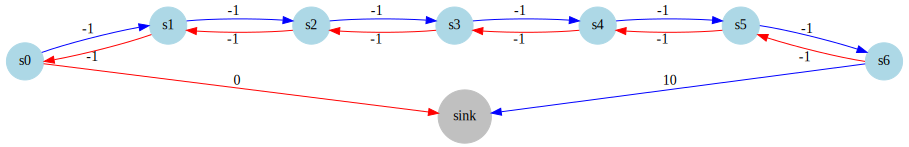

In [ ]:
# @title Chain MDP dynamics
# Set up the length of the chain
chain_length = 7  # @param {type:'slider', min:3, max:10, step:1}
penalty = -1  # @param {type: 'number'}
small_reward = 0  # @param {type: 'number'}
large_reward = 10  # @param {type: 'number'}

### Draw the chain MDP ###
styles = {
    'state':  {'shape': 'circle', 'style': 'filled', 'color': 'lightblue'},
    'sink':  {'shape': 'circle', 'style': 'filled', 'color': 'grey'},
}
chain_mdp = Digraph(engine='neato')
for i in range(chain_length):
  ypos = 0 if i > 0 and i < (chain_length - 1) else -0.5
  chain_mdp.node(f's{i}', f's{i}', styles['state'], pos=f'{i*2},{ypos}!')
chain_mdp.node('sink', 'sink', styles['sink'], pos=f'{chain_length},-5')
for i in range(chain_length):
  l_node = f's{i - 1}' if i > 0 else 'sink'
  reward = small_reward if l_node == 'sink' else penalty
  chain_mdp.edge(f's{i}', l_node, f'{reward}', color='red')
  r_node = f's{i + 1}' if i < (chain_length - 1) else 'sink'
  reward = large_reward if r_node == 'sink' else penalty
  chain_mdp.edge(f's{i}', r_node, f'{reward}', color='blue')
chain_mdp.graph_attr['splines'] = 'true'
chain_mdp

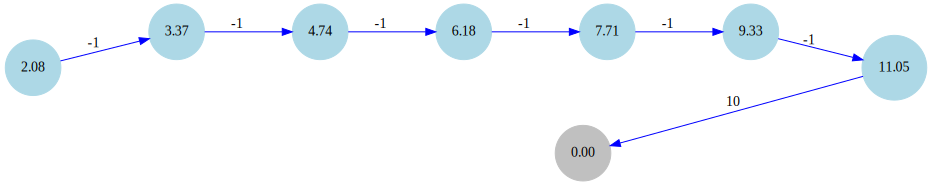

In [ ]:
# @title Compute Q* and V* with value iteration
gamma = 0.95  # @param {type:'slider', min:0, max:0.95, step:0.05}
rho = 0.1  # @param {type:'slider', min:0, max:1.0, step:0.05}
### Compute V* and Q* ###
# We only have two actions (L and R). The following lines create the
# deterministic chain dynamics for left and right actions, where the last state
# is an absorbing state.
P = onp.zeros((chain_length + 1, 2, chain_length + 1))
P[:, 0] =  onp.roll(onp.eye(chain_length + 1) * (1 - rho), -1, axis=1)
P[chain_length, 0] = onp.roll(P[chain_length, 0], 1)  # Sink loops on itself.
P[:, 0] += onp.eye(chain_length + 1) * rho
P[:, 1] =  onp.roll(onp.eye(chain_length + 1) * (1 - rho), 1, axis=1)
P[chain_length, 1] = onp.roll(P[chain_length, 1], -1)  # Sink loops on itself.
P[:, 1] += onp.eye(chain_length + 1) * rho
# The rewards will be `penalty` everywhere, except in transitions to the sink
# state, where they will be `small_reward` for the leftmost move and 
# `large_reward` for the rightmost move.
# The sink state receives reward of 0 for both actions.
R = onp.ones((chain_length + 1, 2)) * penalty
R[0, 0] = small_reward
R[chain_length - 1, 1] = large_reward
R[chain_length] = 0

# Now run value iteration to compute V* and Q* exactly.
V, Q = value_iteration(P, R, gamma)

solved_mdp = Digraph(engine='neato')
for i in range(chain_length):
  ypos = 0 if i > 0 and i < (chain_length - 1) else -0.5
  solved_mdp.node(f's{i}', f'{V[i]:.2f}', styles['state'], pos=f'{i*2},{ypos}!')
solved_mdp.node('sink', f'{V[chain_length]:.2f}', styles['sink'], pos=f'{chain_length},-5')
for i in range(chain_length):
  a = onp.argmax(Q[i])
  l_node = f's{i - 1}' if i > 0 else 'sink'
  r_node = f's{i + 1}' if i < (chain_length - 1) else 'sink'
  l_reward = small_reward if l_node == 'sink' else penalty
  r_reward = large_reward if r_node == 'sink' else penalty
  if a == 0:
    color = 'red'
    next_node = l_node
    reward = l_reward
  else:
    color = 'blue'
    next_node = r_node
    reward = r_reward
  solved_mdp.edge(f's{i}', next_node, f'{reward}', color=color)
solved_mdp

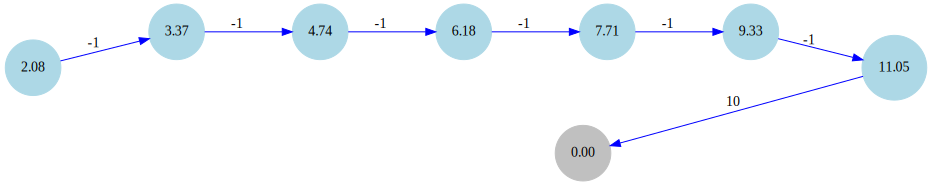

In [ ]:
# @title Compute Q* and V* with policy iteration
### Compute V* and Q* ###
# We only have two actions (L and R). The following lines create the
# deterministic chain dynamics for left and right actions, where the last state
# is an absorbing state.
P = onp.zeros((chain_length + 1, 2, chain_length + 1))
P[:, 0] =  onp.roll(onp.eye(chain_length + 1), -1, axis=1)
P[chain_length, 0] = onp.roll(P[chain_length, 0], 1)  # Sink loops on itself.
P[:, 1] =  onp.roll(onp.eye(chain_length + 1), 1, axis=1)
P[chain_length, 1] = onp.roll(P[chain_length, 1], -1)  # Sink loops on itself.
# The rewards will be `penalty` everywhere, except in transitions to the sink
# state, where they will be `small_reward` for the leftmost move and 
# `large_reward` for the rightmost move.
# The sink state receives reward of 0 for both actions.
R = onp.ones((chain_length + 1, 2)) * penalty
R[0, 0] = small_reward
R[chain_length - 1, 1] = large_reward
R[chain_length] = 0

# Now run value iteration to compute V* and Q* exactly.
V_pol, Q_pol = policy_iteration(P, R, gamma)

solved_mdp = Digraph(engine='neato')
for i in range(chain_length):
  ypos = 0 if i > 0 and i < (chain_length - 1) else -0.5
  solved_mdp.node(f's{i}', f'{V[i]:.2f}', styles['state'], pos=f'{i*2},{ypos}!')
solved_mdp.node('sink', f'{V_pol[chain_length]:.2f}', styles['sink'],
                pos=f'{chain_length},-5')
for i in range(chain_length):
  a = onp.argmax(Q_pol[i])
  l_node = f's{i - 1}' if i > 0 else 'sink'
  r_node = f's{i + 1}' if i < (chain_length - 1) else 'sink'
  l_reward = small_reward if l_node == 'sink' else penalty
  r_reward = large_reward if r_node == 'sink' else penalty
  if a == 0:
    color = 'red'
    next_node = l_node
    reward = l_reward
  else:
    color = 'blue'
    next_node = r_node
    reward = r_reward
  solved_mdp.edge(f's{i}', next_node, f'{reward}', color=color)
solved_mdp

### Interacting with the environment
In the next code cell we define a `step` function that receives a state and action (provided by the agent), and returns a reward and a next state (provided by the environment). This `step` function will be used in the learning experiments below.

In [ ]:
ns = P.shape[0]
na = P.shape[1]
def step_fn(s, a):
  """Receives a state and action, returns reward and next state."""
  return R[s, a], onp.random.choice(ns, p=P[s,a])

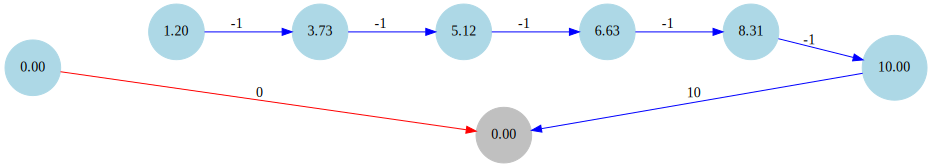

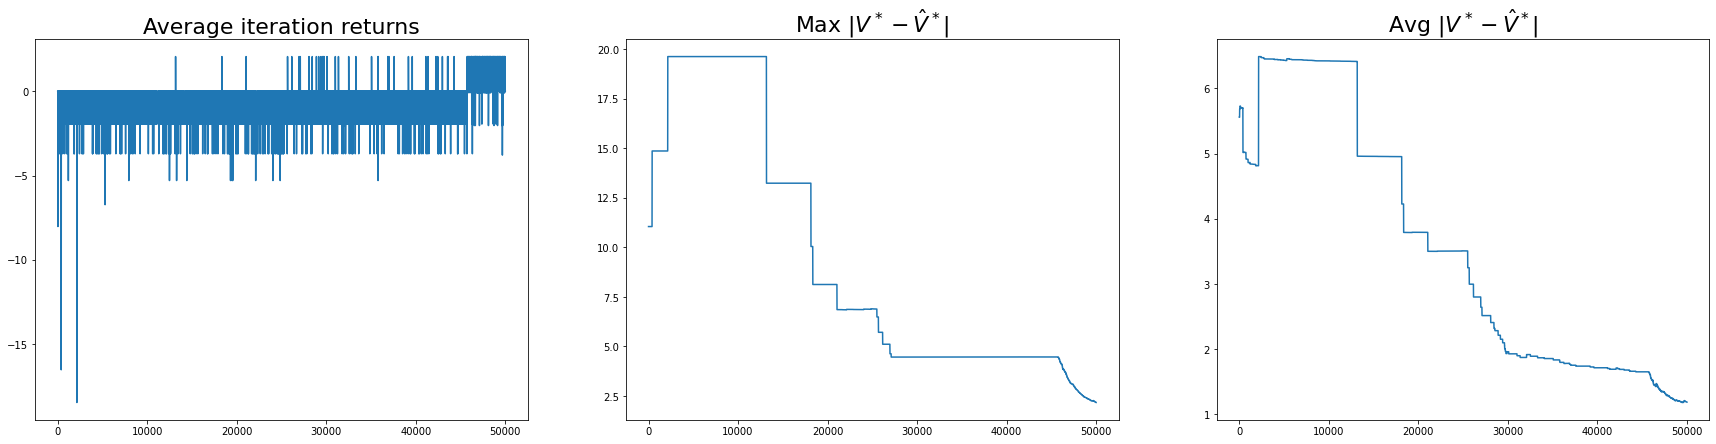

In [ ]:
# @title Monte Carlo on the chain MDP
epsilon = 0.1  # @param {type:'slider', min:0, max:1.0, step:0.05}
total_trajectories = 50000 # @param {type:'slider', min:100, max:100000}
max_steps_per_trajectory = 50 # @param {type:'slider', min:10, max:200}
V_MC, Q_MC, iteration_returns_MC, max_errors_MC, avg_errors_MC = monte_carlo(
    ns,
    na,
    step_fn,
    gamma,
    0,  # start state
    chain_length,  # reset state
    total_trajectories,
    max_steps_per_trajectory,
    epsilon,
    V)  # True V*
fig, axes = plt.subplots(1, 3, figsize=(30, 7))
axes[0].plot(onp.arange(len(iteration_returns_MC)), iteration_returns_MC)
axes[0].set_title('Average iteration returns', fontsize=22)
axes[1].plot(onp.arange(len(max_errors_MC)), max_errors_MC)
axes[1].set_title(r'Max $|V^* - \hat{V}^*|$', fontsize=22)
axes[2].plot(onp.arange(len(avg_errors_MC)), avg_errors_MC)
axes[2].set_title(r'Avg $|V^* - \hat{V}^*|$', fontsize=22)

# Draw the learned value functions
mc_mdp = Digraph(engine='neato')
for i in range(chain_length):
  ypos = 0 if i > 0 and i < (chain_length - 1) else -0.5
  mc_mdp.node(f's{i}', f'{V_MC[i]:.2f}', styles['state'], pos=f'{i*2},{ypos}!')
mc_mdp.node('sink', f'{V_MC[chain_length]:.2f}', styles['sink'], pos=f'{chain_length},-5')
for i in range(chain_length):
  a = onp.argmax(Q_MC[i])
  l_node = f's{i - 1}' if i > 0 else 'sink'
  r_node = f's{i + 1}' if i < (chain_length - 1) else 'sink'
  l_reward = small_reward if l_node == 'sink' else penalty
  r_reward = large_reward if r_node == 'sink' else penalty
  if a == 0:
    color = 'red'
    next_node = l_node
    reward = l_reward
  else:
    color = 'blue'
    next_node = r_node
    reward = r_reward
  mc_mdp.edge(f's{i}', next_node, f'{reward}', color=color)
mc_mdp


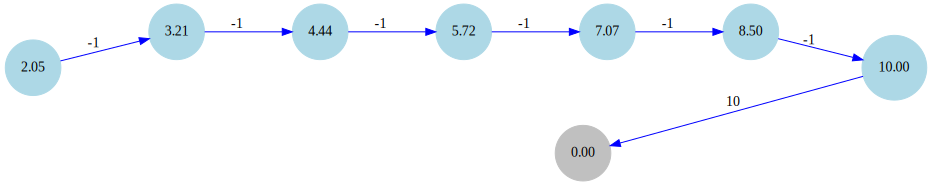

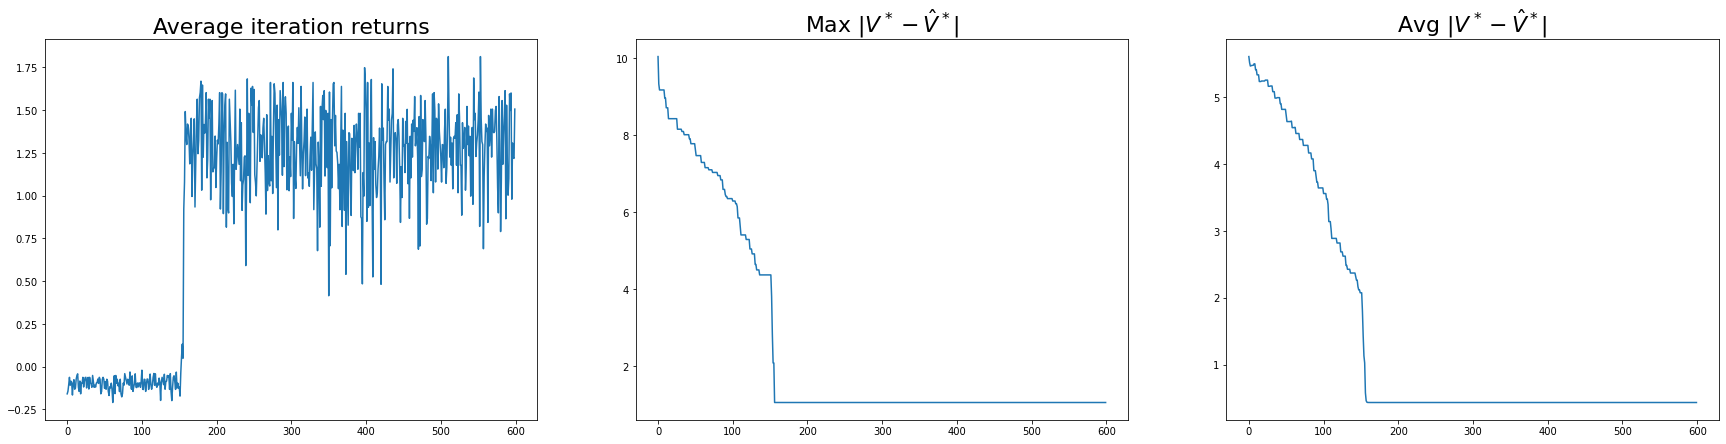

In [ ]:
# @title Q-learning on the chain MDP
alpha = 0.1  # @param {type:'slider', min:0, max:1.0, step:0.05}
epsilon = 0.1  # @param {type:'slider', min:0, max:1.0, step:0.05}
total_episodes = 600 # @param {type:'slider', min:100, max:10000}
max_steps_per_iteration = 200 # @param {type:'slider', min:10, max:200}
V_hat, Q_hat, iteration_returns, max_errors, avg_errors = q_learning(
    ns,
    na,
    step_fn,
    gamma,
    0,  # start state
    chain_length,  # reset state
    total_episodes,
    max_steps_per_iteration,
    epsilon,
    alpha,
    V)  # True V*
fig, axes = plt.subplots(1, 3, figsize=(30, 7))
axes[0].plot(onp.arange(len(iteration_returns)), iteration_returns)
axes[0].set_title('Average iteration returns', fontsize=22)
axes[1].plot(onp.arange(len(max_errors)), max_errors)
axes[1].set_title(r'Max $|V^* - \hat{V}^*|$', fontsize=22)
axes[2].plot(onp.arange(len(avg_errors)), avg_errors)
axes[2].set_title(r'Avg $|V^* - \hat{V}^*|$', fontsize=22)

# Draw the learned value functions
learned_mdp = Digraph(engine='neato')
for i in range(chain_length):
  ypos = 0 if i > 0 and i < (chain_length - 1) else -0.5
  learned_mdp.node(f's{i}', f'{V_hat[i]:.2f}', styles['state'], pos=f'{i*2},{ypos}!')
learned_mdp.node('sink', f'{V_hat[chain_length]:.2f}', styles['sink'], pos=f'{chain_length},-5')
for i in range(chain_length):
  a = onp.argmax(Q_hat[i])
  l_node = f's{i - 1}' if i > 0 else 'sink'
  r_node = f's{i + 1}' if i < (chain_length - 1) else 'sink'
  l_reward = small_reward if l_node == 'sink' else penalty
  r_reward = large_reward if r_node == 'sink' else penalty
  if a == 0:
    color = 'red'
    next_node = l_node
    reward = l_reward
  else:
    color = 'blue'
    next_node = r_node
    reward = r_reward
  learned_mdp.edge(f's{i}', next_node, f'{reward}', color=color)
learned_mdp

# Deep Reinforcement Learning
Although useful for developing a better understanding for MDPs and reinforcement learning, the chain MDP is a tiny problem. One of the main reasons why reinforcement learning has gained much popularity is because of the impressive learning abilities when coupled with neural networks. This is what is meant by _deep reinforcement learning_: RL algorithms combined with (deep) neural networks.

Mathematically, one can think of neural networks as a function approximator $\hat{Q}_\theta$ parameterized by a vector of weights $\theta$. The aim of deep RL is to learn the parameters $\theta$, via interacting with the environment, such that $\hat{Q}_\theta (s) \approx Q^*(s,\cdot)$.

Note that the the learned function approximator $\hat{Q}_{\theta}(s)$ can provide an estimate for all states $s\in\mathcal{S}$, _even those it has never seen before_. If the agent learns a good function approximator, then this will be able to _generalize_ to unseen states in the environment. More specifically, the error $|Q(s, \cdot) - \hat{Q}_\theta(s)|$ will not be too large.

This is in stark contrast to the tabular methods we discussed above, where the agent _must_ visit all states in order to update its estimates for them. This ability to generalize is part of what has granted deep reinforcement learning the ability to tackle such challenging problems.

This idea has been around for quite some time: Gerald Tesauro used it back in 1992 to train an agent to play backgammon (you can read the original paper [here](https://cling.csd.uwo.ca/cs346a/extra/tdgammon.pdf)).

More recently, this idea was used on the [Arcade Learning Environment](https://jair.org/index.php/jair/article/view/10819) (a benchmark suite of 60 Atari 2600 games) in the 2015 paper [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) by Mnih et al. In this paper the authors introduced the DQN algorithm. The algorithm trains a neural network $\hat{Q}_\theta$ that receives as input an array of pixels (a frame in an Atari game), and outputs value estimates for each possible action.

The network parameters in DQN are trained using a _loss function_ that is inspired in the Q-learning update where, given a transition $(s,a)\rightarrow (s',r')$:

$\mathcal{L}(\theta) = \left(R(s, a) +\gamma\max_{a'\in\mathcal{A}}\hat{Q}_{\theta}(s', a') - \hat{Q}_{\theta}(s, a)\right)^2$

Just as the temporal difference update is at the heart of Q-learning, the above loss is at the heart of DQN.

There are a number of technical details that were necessary in order to properly train DQN to perform well on most of the 60 Atari 2600 games. These details are beyond the scope of this notebook, but the interested reader is referred to the paper and to some of the resources listed below.

## Experience replay buffer
One of the core elements of the DQN paper was the use of the experience replay buffer. You can think of this as a large memory where the agent stores experienced transitions, so that the agent can sample from them when learning.

Specifically, after each _step_ in the environment, the agent has an experience transition of the form $\langle s, a, r, s'\rangle$, and it will store this in the replay buffer.

When training, the agent will not use a single transition, but will sample a _batch_ of transitions from the replay buffer. The sampling in DQN is done randomly; that is, if the replay buffer is of size $N$, each stored transition has a probability $\frac{1}{N}$ of being sampled.

The loss function introduced above was defined in terms of a single transition, but it should really be defined in terms of a sampled batch of transitions:

$\mathcal{L}(\theta) = \mathbb{E}_{\langle s,a,r,s'\rangle\sim U(D)}\left[\left(R(s, a) +\gamma\max_{a'\in\mathcal{A}}\hat{Q}_{\theta}(s', a') - \hat{Q}_{\theta}(s, a)\right)^2\right]$

Where $D$ represents the replay buffer and $U(D)$ represents a uniform distribution over the elements in the replay buffer.

Sampling batches in this way also allows us to take advantage of specialized hardware such as GPUs and TPUs, which can speed up training tremendously.

## Final implementation details
There are more implementation details that are beyond the scope of this notebook. The interested reader can go through the full implementations in the dopamine library:
*  Dopamine provides both [TensorFlow](https://github.com/google/dopamine/blob/master/dopamine/discrete_domains/atari_lib.py) and [Jax](https://github.com/google/dopamine/blob/master/dopamine/jax/networks.py) implementations of the DQN network.
*  Dopamine provides both [TensorFlow](https://github.com/google/dopamine/blob/master/dopamine/agents/dqn/dqn_agent.py) and [Jax](https://github.com/google/dopamine/blob/master/dopamine/jax/agents/dqn/dqn_agent.py) implementations of DQN. We will be using the Jax implementation in this notebook.
*  The replay buffer is implemented [here](https://github.com/google/dopamine/blob/master/dopamine/replay_memory/circular_replay_buffer.py).
*  The setup for running a full experiment (environment interaction, reward collection, etc.) is implemented [here](https://github.com/google/dopamine/blob/master/dopamine/discrete_domains/run_experiment.py).

# CartPole example
Training an agent on an Atari game can take multiple days, even on a GPU. Thus, we will focus on a simpler problem: CartPole.

In this problem there is a cart (black block below) attached to a railing (horizontal line), upon which there is a pole (brown rectangle) attached to the cart with a hinge (purple circle). The goal of the agent is to maintain the pole vertically balanced by moving the cart left or right. An episode ends as soon as the pole goes beyond a certain angle.

The agent receives a reward of `1` for each step that it is able to maintain the pole balanced, and `0` otherwise.

The animation below illustrates a trained agent successfully balancing the pole.

![CartPole Illustration](https://user-images.githubusercontent.com/10624937/42135683-dde5c6f0-7d13-11e8-90b1-8770df3e40cf.gif)

Open-AI provides the [gym](https://github.com/openai/gym) library, which gives us access to a number of different environments. Creating a cartpole environment can be done with:

```
import gym
cartpole_env = gym.make('CartPole-v1')
```

The main API methods we will need are:
*  `step`: Receives an action (`int`) and returns 4 objects: the next state, the reward, a boolean indicating whether the environment has ended, and any extra info.
*  `reset`: Reset the environment, returns the initial observation.
*  `render`: Returns an object for rendering, depending on the `mode` parameter passed in. 

See [here](https://github.com/openai/gym/blob/3bd5ef71c2ca3766a26c3dacf87a33a9390ce1e6/gym/core.py) for more details on this API.

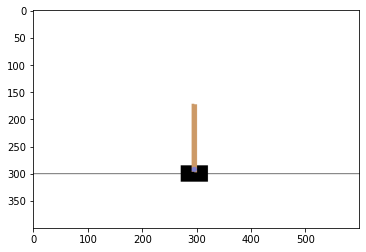

In [ ]:
import gym
cartpole_env = gym.make('CartPole-v1')
cartpole_env.reset()
# This will render the starting state of the environment.
plt.imshow(cartpole_env.render(mode='rgb_array'))

In [ ]:
# @title Animation utilities (run me!)
from matplotlib import animation

def animate_agent(agent, env, num_frames=100):
  s = env.reset()
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  im = axes[0].imshow(env.render(mode='rgb_array'))
  frames = [env.render(mode='rgb_array')]
  returns = [0]
  env_active = True
  for step in range(num_frames):
    a = agent(s)
    s, r, done, _ = env.step(a)
    frames.append(env.render(mode='rgb_array'))
    returns.append(r + returns[-1])
    if env_active and done:
      env_active = False
      print(f'Game over! Your agent lasted {step} steps.')
  axes[1].set_title('Cumulative returns', fontsize=20)
  axes[1].set_xlim(0, num_frames)
  axes[1].set_ylim(0, max(returns) * 1.2)
  line, = axes[1].plot([], [], lw=2)

  def init():
    line.set_data([], [])
    im.set_data(frames[0])
    return [im]
  
  def animate(i):
    line.set_data(onp.arange(i), returns[:i])
    im.set_data(frames[i])
    return [im]
  
  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=num_frames,
                                 interval=50)
  plt.close()
  return HTML(anim.to_jshtml())

## Controlling cartpole with a "blind" policy
We can control cartpole by encoding a "blind" policy that always chooses the _left_ action. This is indicated in the next code cell.

These types of policies are known as _open-loop_ policies (in contrast to _closed-loop_ policies, which are the ones we've been discussing where the action choice is conditional on the agent's state).

We have created a utility `animate_agent` function that receives a function which receives a state and returns an action (the agent), and a Gym environment,
and will generate an animation of the environment as well as the cumulative returns received.

Notice that with this poor open-loop policy the agent is not able to achieve a very high cumulative reward!

In [ ]:
def only_left(unused_s):
  # This will only return the 'left' action, ignoring state.
  return 0

animate_agent(only_left, cartpole_env, num_frames=50)

Game over! Your agent lasted 8 steps.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Training a CartPole agent with dopamine
We are now ready to train our first deep RL agent!

Here is the CartPole DQN network as provided by dopamine.

```
class CartpoleDQNNetwork(nn.Module):
  """Jax DQN network for Cartpole."""

  def apply(self, x, num_actions):
    initializer = nn.initializers.xavier_uniform()
    # We need to add a "batch dimension" as nn.Conv expects it, yet vmap will
    # have removed the true batch dimension.
    x = x[None, ...]
    x = x.astype(jnp.float32)
    x = x.reshape((x.shape[0], -1))  # flatten
    x -= gym_lib.CARTPOLE_MIN_VALS
    x /= gym_lib.CARTPOLE_MAX_VALS - gym_lib.CARTPOLE_MIN_VALS
    x = 2.0 * x - 1.0  # Rescale in range [-1, 1].
    x = nn.Dense(x, features=512, kernel_init=initializer)
    x = jax.nn.relu(x)
    x = nn.Dense(x, features=512, kernel_init=initializer)
    x = jax.nn.relu(x)
    q_values = nn.Dense(x, features=num_actions, kernel_init=initializer)
    return q_values
```

The next code cell creates a dopamine DQN agent with the network specified above.

Dopamine uses a python configuration framework called [gin](https://github.com/google/gin-config) that makes it easy to specify hyperparameters for all the objects in your system (agent, replay buffer, etc.).

In [ ]:
from dopamine.jax import networks
from dopamine.jax.agents.dqn import dqn_agent
import gin

cartpole_config = """
JaxDQNAgent.gamma = 0.99
JaxDQNAgent.update_horizon = 1
JaxDQNAgent.min_replay_history = 500
JaxDQNAgent.update_period = 4
JaxDQNAgent.target_update_period = 100
JaxDQNAgent.epsilon_fn = @dqn_agent.identity_epsilon

create_optimizer.name = 'adam'
create_optimizer.learning_rate = 0.001
create_optimizer.eps = 3.125e-4

OutOfGraphReplayBuffer.replay_capacity = 50000
OutOfGraphReplayBuffer.batch_size = 128
"""
gin.parse_config(cartpole_config, skip_unknown=False)

dqn_agent = dqn_agent.JaxDQNAgent(num_actions=cartpole_env.action_space.n,
                                  observation_shape=(4, 1),
                                  observation_dtype=jnp.float64,
                                  stack_size=1,
                                  network=networks.CartpoleDQNNetwork)

## Animate a newly initialized DQN agent
First we will animate the agent interacting with CartPole before it has learnt anything. This should be roughly a purely random policy.

In [ ]:
def learned_policy(s):
  return dqn_agent.step(0., s)  # We pass in a dummy reward

# We set our agent in `eval_mode` to avoid it from continuing to train while
# interacting with the environment.
dqn_agent.eval_mode = True
animate_agent(learned_policy, cartpole_env, num_frames=100)

Game over! Your agent lasted 10 steps.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Now we train the agent! This is a slimmed-down version of what is done in the dopamine [run_experiment](https://github.com/google/dopamine/blob/master/dopamine/discrete_domains/run_experiment.py) library.

Training proceeds by a sequence of _iterations_, where each iteration consists of one or more _episodes_. Specifically, the parameters that control the training procedure are:
*  `max_steps_per_episode`: this is the maximum number of allowable steps in an episode. Note that this then specifies the maximum possible cumulative reward that the agent can receive.
*  `training_steps`: The minimum number of training steps in an iteration. The agent will execute as many episodes as necessary in order to achieve this minimum.
*  `num_iterations`: The total number of iterations to execute during training. With the settings below, typically 30 iterations is enough to converge to a good policy.

In [ ]:
max_steps_per_episode = 200  # @param {type:'slider', min:10, max:1000}
training_steps = 1000  # @param {type:'slider', min:10, max:5000}
num_iterations = 30  # @param {type:'slider', min:10, max:200}

# First remove eval mode!
dqn_agent.eval_mode = False
average_returns = []
# Each iteration will consist of a number of episodes.
for iteration in range(num_iterations):
  step_count = 0
  num_episodes = 0
  sum_returns = 0.
  # This while loop will continue running episodes until we've done enough
  # training steps.
  while step_count < training_steps:
    episode_length = 0
    episode_rewards = 0.
    s = cartpole_env.reset()
    a = dqn_agent.begin_episode(s)
    is_terminal = False
    # Run the episode until termination.
    while True:
      s, r, done, _ = cartpole_env.step(a)
      episode_rewards += r
      episode_length += 1
      if done or episode_length == max_steps_per_episode:
        # Stop the loop if the episode or ended or we've reached the max steps.
        break
      else:
        a = dqn_agent.step(r, s)
    dqn_agent.end_episode(r)
    step_count += episode_length
    sum_returns += episode_rewards
    num_episodes += 1
  average_return = sum_returns / num_episodes if num_episodes > 0 else 0.
  print(f'Iteration {iteration}: average return = {average_return:.4f}')
  average_returns.append(average_return)

Iteration 0: average return = 9.8039
Iteration 1: average return = 12.9625
Iteration 2: average return = 98.0909
Iteration 3: average return = 84.6667
Iteration 4: average return = 87.3333
Iteration 5: average return = 88.8333
Iteration 6: average return = 83.6667
Iteration 7: average return = 83.8333
Iteration 8: average return = 87.5000
Iteration 9: average return = 90.8333
Iteration 10: average return = 93.5455
Iteration 11: average return = 104.2000
Iteration 12: average return = 100.5000
Iteration 13: average return = 94.0909
Iteration 14: average return = 93.1818
Iteration 15: average return = 100.6000
Iteration 16: average return = 109.2000
Iteration 17: average return = 103.1000
Iteration 18: average return = 138.6250
Iteration 19: average return = 149.8571
Iteration 20: average return = 148.5714
Iteration 21: average return = 147.2857
Iteration 22: average return = 128.6250
Iteration 23: average return = 105.3000
Iteration 24: average return = 148.5714
Iteration 25: average re

## Animate trained DQN agent
Now we can animate our trained agent. If training was successful, this should be animating a well-balanced pole!

In [ ]:
def learned_policy(s):
  return dqn_agent.step(0., s)  # We pass in a dummy reward

# We set our agent in `eval_mode` to avoid it from continuing to train while
# interacting with the environment.
dqn_agent.eval_mode = True
animate_agent(learned_policy, cartpole_env, num_frames=100)

# Further reading
I hope you found this notebook useful. Here are some resources to continue your voyage into the depths of reinforcement learning!

*  The canonical reference for reinforcement learning is the [Reinforcement Learning book by Sutton and Barto](http://www.incompleteideas.net/book/the-book-2nd.html).
*  The Open-AI [spinning up in deep RL](https://spinningup.openai.com/en/latest/)
*  The [dopamine repository](https://github.com/google/dopamine)
*  [Temporal Difference Learning and TD-Gammon](https://cling.csd.uwo.ca/cs346a/extra/tdgammon.pdf) by Gerald Tesauro
*  [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) by Mnih et al. 